# Player Detection

## GPU + Drive

In [13]:
# Check GPU
!nvidia-smi -L || echo "No GPU detected (enable GPU: Runtime → Change runtime type)"

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Base path in Drive
BASE = "/content/drive/MyDrive/DS5216"
print("Using base:", BASE)


GPU 0: Tesla T4 (UUID: GPU-3bdcecb9-3880-9f08-bc26-f0853d275559)
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using base: /content/drive/MyDrive/DS5216


## Install dependencies

In [26]:
!pip -q install ultralytics==8.3.34 supervision==0.22.0 opencv-python-headless==4.10.0.84 yt-dlp==2024.10.07
!apt -y install ffmpeg > /dev/null


##  Imports & folders

In [27]:
from pathlib import Path
import os, glob, json, cv2, numpy as np, pandas as pd
from ultralytics import YOLO
from datetime import datetime
from IPython.display import Video, display

# Folders
DATA_DIR = Path(BASE) / "data"
VID_DIR  = DATA_DIR / "videos"
OUT_DIR  = Path(BASE) / "outputs"
SS_DIR   = Path(BASE) / "screenshots"
for p in [DATA_DIR, VID_DIR, OUT_DIR, SS_DIR]:
    p.mkdir(parents=True, exist_ok=True)

print("Folders:")
print("-", VID_DIR)
print("-", OUT_DIR)
print("-", SS_DIR)


Folders:
- /content/drive/MyDrive/DS5216/data/videos
- /content/drive/MyDrive/DS5216/outputs
- /content/drive/MyDrive/DS5216/screenshots


## Add videos

In [28]:
# List videos found
videos = sorted(glob.glob(str(VID_DIR / "*.mp4")) +
                glob.glob(str(VID_DIR / "*.mkv")) +
                glob.glob(str(VID_DIR / "*.mov")) +
                glob.glob(str(VID_DIR / "*.webm")))
print(f"Found {len(videos)} video(s):")
for v in videos: print("-", Path(v).name)

Found 6 video(s):
- video 1.mp4
- video 2.mp4
- video 3.mp4
- video 4.mp4
- video 5.mp4
- video 6.mp4


## Load model

In [29]:
det_model = YOLO("yolov8n.pt")
PERSON_CLASS_ID = 0
print("yolov8n.pt Model ready.")


yolov8n.pt Model ready.


## Tracking

In [31]:
def track(
    src_path,
    save_prefix="yolo8n",
    conf=0.35,
    iou=0.45,
    tracker="bytetrack.yaml",
    take_screens=5
):
    src = Path(src_path)
    name = src.stem.strip().replace(" ", "_")

    # Probe video for size/FPS
    cap = cv2.VideoCapture(str(src))
    if not cap.isOpened():
        raise RuntimeError(f"Cannot open video: {src}")
    fps = cap.get(cv2.CAP_PROP_FPS) or 30.0
    if fps <= 1: fps = 30.0
    width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)) or 1280
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)) or 720
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) or 0
    cap.release()

    # Output paths
    out_video_path = OUT_DIR /"Player Detection"/ f"{save_prefix}_{name}_tracked.mp4"
    out_json_path  = OUT_DIR /"Player Detection"/f"{save_prefix}_{name}_stats.json"

    # VideoWriter (MP4 → fallback to AVI if needed)
    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    writer = cv2.VideoWriter(str(out_video_path), fourcc, fps, (width, height))
    if not writer.isOpened():
        out_video_path = OUT_DIR / f"{save_prefix}_{name}_tracked.avi"
        fourcc = cv2.VideoWriter_fourcc(*"MJPG")
        writer = cv2.VideoWriter(str(out_video_path), fourcc, fps, (width, height))
        if not writer.isOpened():
            raise RuntimeError("Failed to open VideoWriter for both MP4 and AVI.")

    # Screenshots positions
    shot_positions = []
    if total_frames > 0:
        take = min(take_screens, total_frames) if total_frames < take_screens else take_screens
        shot_positions = [int((i+1) * total_frames / (take+1)) for i in range(take)]
    screenshot_buffer = {}

    # Stats
    frame_idx = 0
    frame_counts = []
    track_ids_seen = set()
    id_switches = 0
    prev_frame_ids = set()

    # Stream detections (no RAM buildup)
    gen = det_model.track(
        source=str(src),
        conf=conf, iou=iou, classes=[PERSON_CLASS_ID],
        tracker=tracker,
        save=False, stream=True, verbose=False
    )

    for r in gen:
        frame = r.plot()           # annotated frame (BGR)
        writer.write(frame)

        # Stats via track IDs
        ids = []
        if r.boxes is not None and r.boxes.id is not None:
            ids = [int(x) for x in r.boxes.id.cpu().numpy().tolist()]
        frame_counts.append(len(ids))
        new_ids = set(ids)
        appeared = new_ids - prev_frame_ids
        disappeared = prev_frame_ids - new_ids
        if appeared and disappeared:
            id_switches += min(len(appeared), len(disappeared))
        prev_frame_ids = new_ids
        track_ids_seen.update(ids)

        # Save screenshots
        if frame_idx in shot_positions:
            screenshot_buffer[frame_idx] = frame.copy()
        frame_idx += 1

    writer.release()

    # Write screenshots
    for pos, img in screenshot_buffer.items():
        cv2.imwrite(str(SS_DIR / f"{save_prefix}_{name}_frame{pos}.jpg"), img)

    # Save stats
    stats = {
        "video": src.name,
        "frames_processed": len(frame_counts),
        "mean_persons_per_frame": float(np.mean(frame_counts)) if frame_counts else 0.0,
        "max_persons_in_frame": int(np.max(frame_counts)) if frame_counts else 0,
        "unique_track_ids": len(track_ids_seen),
        "approx_id_switches": int(id_switches),
        "conf": conf, "iou": iou, "tracker": tracker,
        "timestamp": datetime.now().isoformat(timespec="seconds"),
    }
    with open(out_json_path, "w") as f:
        json.dump(stats, f, indent=2)

    print("Saved video:", out_video_path)
    print("Saved stats:", out_json_path)
    return out_video_path, out_json_path


## 6) Run on all videos

In [33]:
generated = []
for v in videos:
    out_vid, out_json = track(v, save_prefix="yolo8n")
    generated.append((out_vid, out_json))

print("\nGenerated files:")
for v, j in generated:
    print("-", Path(v).name, "|", Path(j).name)



Saved video: /content/drive/MyDrive/DS5216/outputs/yolo8n_video_1_tracked.avi
Saved stats: /content/drive/MyDrive/DS5216/outputs/Player Detection/yolo8n_video_1_stats.json
Saved video: /content/drive/MyDrive/DS5216/outputs/Player Detection/yolo8n_video_2_tracked.mp4
Saved stats: /content/drive/MyDrive/DS5216/outputs/Player Detection/yolo8n_video_2_stats.json
Saved video: /content/drive/MyDrive/DS5216/outputs/Player Detection/yolo8n_video_3_tracked.mp4
Saved stats: /content/drive/MyDrive/DS5216/outputs/Player Detection/yolo8n_video_3_stats.json
Saved video: /content/drive/MyDrive/DS5216/outputs/Player Detection/yolo8n_video_4_tracked.mp4
Saved stats: /content/drive/MyDrive/DS5216/outputs/Player Detection/yolo8n_video_4_stats.json
Saved video: /content/drive/MyDrive/DS5216/outputs/Player Detection/yolo8n_video_5_tracked.mp4
Saved stats: /content/drive/MyDrive/DS5216/outputs/Player Detection/yolo8n_video_5_stats.json
Saved video: /content/drive/MyDrive/DS5216/outputs/Player Detection/yolo

##  Make a CSV summary

In [34]:
rows = []
for js in glob.glob(str(OUT_DIR / "*_stats.json")):
    with open(js) as f:
        rows.append(json.load(f))
df = pd.DataFrame(rows)
if not df.empty:
    df = df[["video","frames_processed","mean_persons_per_frame","max_persons_in_frame",
             "unique_track_ids","approx_id_switches","conf","iou","tracker","timestamp"]]
    df.sort_values("video", inplace=True, ignore_index=True)

csv_path = OUT_DIR / "tracking_summary.csv"
df.to_csv(csv_path, index=False)
print("Saved:", csv_path)
df


Saved: /content/drive/MyDrive/DS5216/outputs/tracking_summary.csv


""


## Fine-tune model

In [35]:
DATA_YAML = f"{BASE}/data/person_dataset/person.yaml"
PROJECT_TRAIN = f"{BASE}/exp_det_train"

model = YOLO("yolov8n.pt")
r = model.train(
    data=DATA_YAML, epochs=20, imgsz=640, batch=16, device=0,
    project=PROJECT_TRAIN, name="person_y8n_ft", verbose=False
)
best = Path(r.save_dir) / "weights/best.pt"
best


New https://pypi.org/project/ultralytics/8.3.217 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.34 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/drive/MyDrive/DS5216/data/person_dataset/person.yaml, epochs=20, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=/content/drive/MyDrive/DS5216/exp_det_train, name=person_y8n_ft, exist_ok=False, pretrained=True, optimizer=auto, verbose=False, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_

100%|██████████| 755k/755k [00:00<00:00, 17.5MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 76.2MB/s]


AMP: checks passed ✅


train: Scanning /content/drive/MyDrive/DS5216/data/person_dataset/labels/train.cache... 240 images, 0 backgrounds, 0 corrupt: 100%|██████████| 240/240 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.12/dist-packages/ultralytics/data/augment.py:1850: UserWarning: Argument(s) 'quality_lower' are not valid for transform ImageCompression
  A.ImageCompression(quality_lower=75, p=0.0),
val: Scanning /content/drive/MyDrive/DS5216/data/person_dataset/labels/val.cache... 60 images, 0 backgrounds, 0 corrupt: 100%|██████████| 60/60 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/DS5216/exp_det_train/person_y8n_ft/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/DS5216/exp_det_train/person_y8n_ft
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      2.34G      1.004      2.134      1.168        145        640: 100%|██████████| 15/15 [00:08<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.14s/it]

                   all         60        243          1      0.238       0.56      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      2.21G     0.8808      1.028      1.064        123        640: 100%|██████████| 15/15 [00:06<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.27it/s]

                   all         60        243      0.965      0.506      0.631      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      2.21G     0.8335     0.9332      1.048        106        640: 100%|██████████| 15/15 [00:04<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.02it/s]

                   all         60        243      0.911      0.508      0.676      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      2.22G     0.8443      0.914      1.044         91        640: 100%|██████████| 15/15 [00:07<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.73it/s]

                   all         60        243      0.872      0.617      0.775      0.591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      2.21G     0.8313       0.88      1.031        176        640: 100%|██████████| 15/15 [00:04<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.08it/s]

                   all         60        243      0.865      0.605      0.755      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      2.26G     0.8455     0.8615      1.046        186        640: 100%|██████████| 15/15 [00:06<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.58it/s]

                   all         60        243       0.87      0.823      0.898      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      2.24G     0.8374     0.8315      1.026        186        640: 100%|██████████| 15/15 [00:05<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.57it/s]

                   all         60        243       0.87       0.79      0.887       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      2.26G     0.7984     0.7862      1.017        177        640: 100%|██████████| 15/15 [00:04<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.41it/s]

                   all         60        243      0.941      0.914      0.962      0.757



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      2.25G     0.7852     0.7699      1.008        131        640: 100%|██████████| 15/15 [00:06<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.49it/s]

                   all         60        243      0.924      0.914      0.964      0.754



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      2.23G     0.7477     0.7221      1.001        157        640: 100%|██████████| 15/15 [00:04<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.78it/s]

                   all         60        243      0.954       0.93      0.962      0.773


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.12/dist-packages/ultralytics/data/augment.py:1850: UserWarning: Argument(s) 'quality_lower' are not valid for transform ImageCompression
  A.ImageCompression(quality_lower=75, p=0.0),



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      2.19G     0.6233     0.7847     0.9231        108        640: 100%|██████████| 15/15 [00:09<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.03it/s]

                   all         60        243      0.953      0.914      0.963      0.793



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20       2.2G     0.6434     0.7226     0.9368         47        640: 100%|██████████| 15/15 [00:06<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.49it/s]

                   all         60        243      0.944      0.897      0.961      0.779



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      2.19G     0.6448     0.7108     0.9164         88        640: 100%|██████████| 15/15 [00:04<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.67it/s]

                   all         60        243      0.934      0.939      0.974      0.793



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      2.21G     0.6168     0.6725     0.9124         54        640: 100%|██████████| 15/15 [00:07<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.62it/s]

                   all         60        243      0.941      0.925      0.979      0.812



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      2.19G     0.5888     0.6488      0.894         73        640: 100%|██████████| 15/15 [00:05<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.89it/s]

                   all         60        243      0.957      0.926      0.982      0.817



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      2.19G     0.5689     0.6286      0.899         66        640: 100%|██████████| 15/15 [00:04<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.20it/s]

                   all         60        243      0.942      0.939      0.982      0.829



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      2.21G      0.526     0.5912      0.884         72        640: 100%|██████████| 15/15 [00:07<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.36it/s]

                   all         60        243      0.937      0.963      0.981      0.842



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      2.21G     0.5109     0.5799     0.8863         46        640: 100%|██████████| 15/15 [00:04<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.94it/s]

                   all         60        243      0.916      0.975      0.977      0.841



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      2.21G     0.5078     0.5733     0.8814         71        640: 100%|██████████| 15/15 [00:05<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.56it/s]

                   all         60        243      0.925      0.966      0.975      0.838



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      2.19G     0.4912     0.5537     0.8625         60        640: 100%|██████████| 15/15 [00:04<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.05it/s]

                   all         60        243      0.924      0.975      0.977      0.848



20 epochs completed in 0.050 hours.
Optimizer stripped from /content/drive/MyDrive/DS5216/exp_det_train/person_y8n_ft/weights/last.pt, 6.2MB
Optimizer stripped from /content/drive/MyDrive/DS5216/exp_det_train/person_y8n_ft/weights/best.pt, 6.2MB

Validating /content/drive/MyDrive/DS5216/exp_det_train/person_y8n_ft/weights/best.pt...
Ultralytics 8.3.34 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


                   all         60        243      0.924      0.975      0.977      0.848
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to /content/drive/MyDrive/DS5216/exp_det_train/person_y8n_ft


PosixPath('/content/drive/MyDrive/DS5216/exp_det_train/person_y8n_ft/weights/best.pt')

## Plot training loss curves

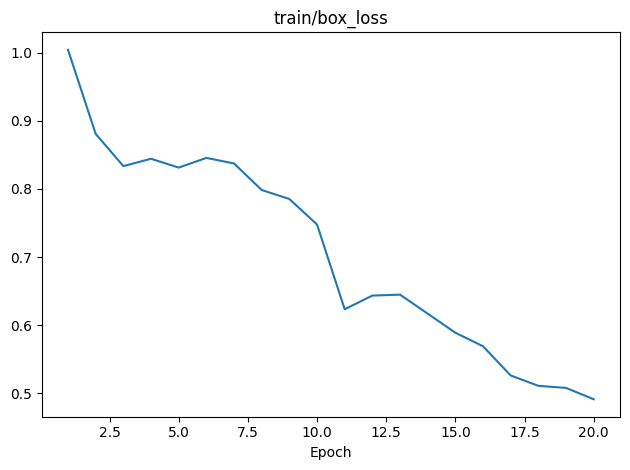

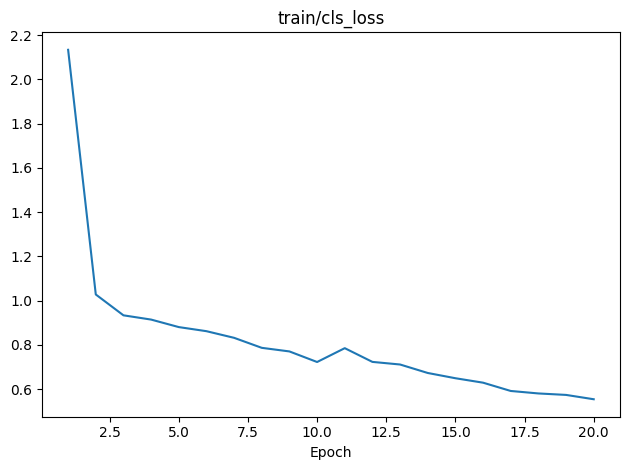

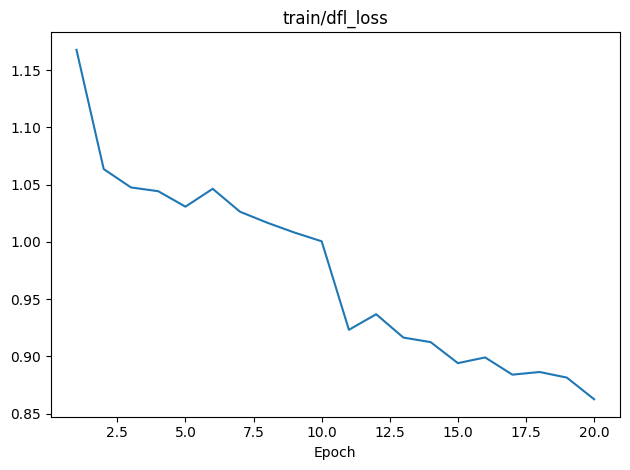

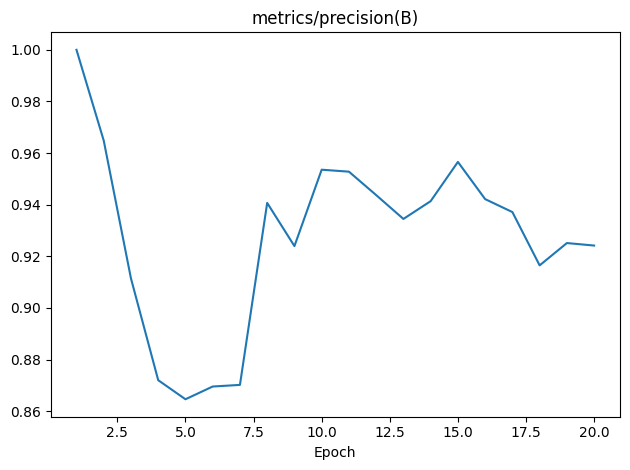

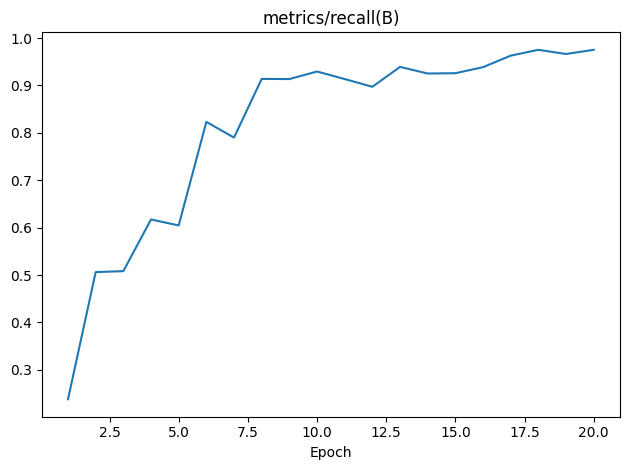

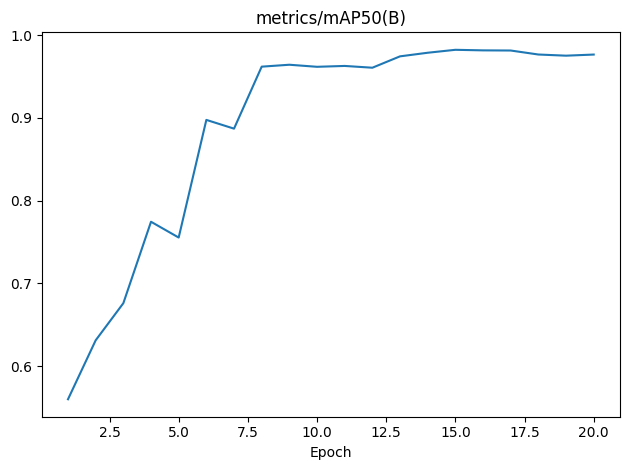

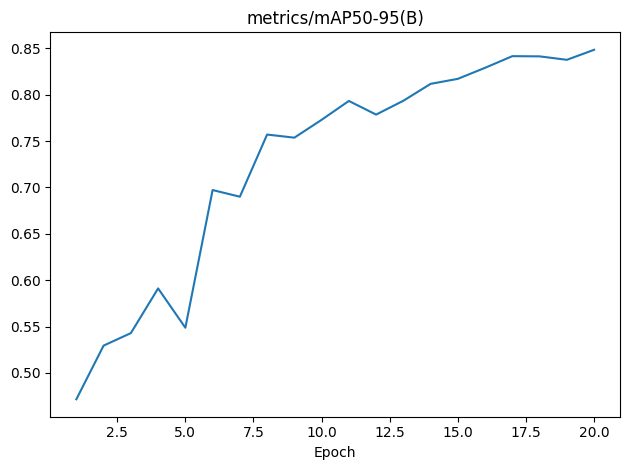

In [36]:
import pandas as pd, matplotlib.pyplot as plt, glob, os

csv = sorted(glob.glob(f"{PROJECT_TRAIN}/person_y8n_ft/results.csv"))[-1]
df = pd.read_csv(csv)

for col in ["train/box_loss","train/cls_loss","train/dfl_loss",
            "metrics/precision(B)","metrics/recall(B)","metrics/mAP50(B)","metrics/mAP50-95(B)"]:
    if col in df.columns:
        plt.figure()
        plt.plot(df["epoch"], df[col])
        plt.title(col)
        plt.xlabel("Epoch"); plt.tight_layout(); plt.show()


## Validate baseline vs fine-tuned on the same val set

In [37]:
import pandas as pd
from ultralytics import YOLO

DATA_YAML = f"{BASE}/data/person_dataset/person.yaml"
PROJECT_VAL = f"{BASE}/exp_det_eval2"
weights_to_compare = ["yolov8n.pt", str(best)]  # baseline vs fine-tuned
rows = []

for w in weights_to_compare:
    res = YOLO(w).val(data=DATA_YAML, imgsz=640, plots=True, save_json=True,
                      project=PROJECT_VAL, name=f"val_{Path(w).stem}", verbose=False)
    d = res.results_dict
    rows.append({
        "weights": Path(w).name,
        "mAP50-95": d.get("metrics/mAP50-95(B)", d.get("metrics/mAP50-95")),
        "mAP50":    d.get("metrics/mAP50(B)",    d.get("metrics/mAP50")),
        "precision":d.get("metrics/precision(B)",d.get("precision")),
        "recall":   d.get("metrics/recall(B)",   d.get("recall")),
        "inference_ms": d.get("speed/inference")
    })

df_cmp = pd.DataFrame(rows)
df_cmp


Ultralytics 8.3.34 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 168 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


val: Scanning /content/drive/MyDrive/DS5216/data/person_dataset/labels/val.cache... 60 images, 0 backgrounds, 0 corrupt: 100%|██████████| 60/60 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.14it/s]


                   all         60        243       0.92      0.807      0.927      0.744
Speed: 0.6ms preprocess, 11.5ms inference, 0.0ms loss, 6.4ms postprocess per image
Saving /content/drive/MyDrive/DS5216/exp_det_eval2/val_yolov8n/predictions.json...
Results saved to /content/drive/MyDrive/DS5216/exp_det_eval2/val_yolov8n
Ultralytics 8.3.34 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /content/drive/MyDrive/DS5216/data/person_dataset/labels/val.cache... 60 images, 0 backgrounds, 0 corrupt: 100%|██████████| 60/60 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.48it/s]


                   all         60        243      0.924      0.975      0.977      0.848
Speed: 0.5ms preprocess, 5.9ms inference, 0.0ms loss, 5.6ms postprocess per image
Saving /content/drive/MyDrive/DS5216/exp_det_eval2/val_best/predictions.json...
Results saved to /content/drive/MyDrive/DS5216/exp_det_eval2/val_best


,weights,mAP50-95,mAP50,precision,recall,inference_ms
0,yolov8n.pt,0.743895,0.927129,0.919550,0.806584,None
1,best.pt,0.847862,0.976579,0.924074,0.975309,None


## Export a clean table & copy key figures

In [38]:
cmp_csv = f"{BASE}/outputs/det_comparison.csv"
Path(f"{BASE}/outputs").mkdir(parents=True, exist_ok=True)
df_cmp.to_csv(cmp_csv, index=False)
print("Saved:", cmp_csv)

Saved: /content/drive/MyDrive/DS5216/outputs/det_comparison.csv


## Choose a confidence threshold using F1 vs threshold

In [39]:
import json, numpy as np, matplotlib.pyplot as plt, glob

for pr_json in glob.glob(f"{PROJECT_VAL}/val_*/PR_curve.json"):
    with open(pr_json) as f: pr = json.load(f)
    conf = np.array(pr["confidence"]); P = np.array(pr["precision"]); R = np.array(pr["recall"])
    F1 = 2*(P*R)/(P+R+1e-9)
    plt.figure(); plt.plot(conf, F1); plt.title(pr_json.split("/")[-2]+" F1 vs conf")
    plt.xlabel("Confidence"); plt.ylabel("F1"); plt.grid(True, alpha=.3); plt.show()


## Speed benchmark (ms per image) at your target resolution

In [41]:
from ultralytics import YOLO
import time, cv2, glob

test_imgs = glob.glob(f"{BASE}/data/person_dataset/images/val/*.jpg")[:10]
model = YOLO(str(best))  # or "yolov8n.pt"
t=[]
for im in test_imgs:
    s=time.time(); model.predict(source=im, imgsz=640, conf=0.25, classes=[0], verbose=False)
    t.append((time.time()-s)*1000)
print(f"Inference ms/img (mean±std): {np.mean(t):.1f} ± {np.std(t):.1f}")


Inference ms/img (mean±std): 30.5 ± 29.9


# 2. Keypoint Detection

## Imports, constants, folders

In [43]:
SS_DIR  = Path(BASE) / "screens"

for p in [OUT_DIR, SS_DIR, OUT_DIR / "Keypoint Detection"]:
    p.mkdir(parents=True, exist_ok=True)

# Person class id for COCO
PERSON_CLASS_ID = 0

# Colors (BGR)
C_RED  = (0, 0, 255)
C_BLUE = (255, 0, 0)
C_DARK = (0, 0, 0)

print("Folders ready:", OUT_DIR, SS_DIR)

Folders ready: /content/drive/MyDrive/DS5216/outputs /content/drive/MyDrive/DS5216/screens


## YOLO-pose loader

In [45]:
from ultralytics import YOLO

pose_model = YOLO("yolov8s-pose.pt")
print("Pose model ready.")


Pose model ready.


## edges and landmark helpers (HEAD / FISTS / FEET)

In [46]:
# COCO-17 skeleton edges
COCO_EDGES = [
    (5,7),(7,9), (6,8),(8,10),
    (11,13),(13,15), (12,14),(14,16),
    (5,6), (11,12), (5,11),(6,12),
    (0,1),(1,2),(2,3),(3,4)
]

def get_kpts_xyc(result, det_index):

    kobj = getattr(result, "keypoints", None)
    if kobj is None:
        return None, None

    # Prefer .data
    if hasattr(kobj, "data") and kobj.data is not None:
        arr = kobj.data.cpu().numpy()  # [N, 17, 3] or [N, 17, 2]
        if det_index >= arr.shape[0]:
            return None, None
        this = arr[det_index]
        if this.shape[-1] == 3:
            xy = this[:, :2]
            cf = this[:, 2]
        else:
            xy = this[:, :2]
            cf = np.ones((xy.shape[0],), dtype=float)
        return xy, cf

    # Fallback: .xy (positions only)
    if hasattr(kobj, "xy") and kobj.xy is not None:
        arr = kobj.xy.cpu().numpy()  # [N, 17, 2]
        if det_index >= arr.shape[0]:
            return None, None
        xy = arr[det_index]
        cf = np.ones((xy.shape[0],), dtype=float)
        return xy, cf

    return None, None

def get_head_point(xy, conf, conf_thr=0.25):
    """
    A robust single "head" point:
    - prefer nose (idx 0) if confident,
    - else mean of eyes (1,2),
    - else mean of shoulders (5,6),
    - else fall back to nose.
    """
    if xy is None:
        return None
    if conf is None or (len(conf)>0 and conf[0] >= conf_thr):
        return xy[0]
    if len(xy) > 2:
        eyes = [xy[1], xy[2]]
        if eyes[0] is not None and eyes[1] is not None:
            return np.mean(np.stack(eyes), axis=0)
    if len(xy) > 6:
        sh = [xy[5], xy[6]]
        if sh[0] is not None and sh[1] is not None:
            return np.mean(np.stack(sh), axis=0)
    return xy[0]

def get_fists(xy, conf=None):
    """
    Fists == wrists (left=9, right=10).
    Returns dict {'left','right','best'}
    """
    if xy is None:
        return {"left": None, "right": None, "best": None}
    lw = xy[9]  if len(xy) > 9  else None
    rw = xy[10] if len(xy) > 10 else None
    if conf is None:
        best = lw if lw is not None else rw
    else:
        lc = conf[9]  if len(conf) > 9  else 0.0
        rc = conf[10] if len(conf) > 10 else 0.0
        best = lw if lc >= rc else rw
    return {"left": lw, "right": rw, "best": best}

def get_feet(xy):
    """
    Feet == ankles (left=15, right=16). Also returns 'lower' (closer to the floor in image coords).
    """
    if xy is None:
        return {"left": None, "right": None, "lower": None, "higher": None}
    la = xy[15] if len(xy) > 15 else None
    ra = xy[16] if len(xy) > 16 else None
    cand = [p for p in [la, ra] if p is not None]
    if not cand:
        return {"left": la, "right": ra, "lower": None, "higher": None}
    lower = max(cand, key=lambda p: p[1])   # larger y → lower on screen
    higher = min(cand, key=lambda p: p[1])
    return {"left": la, "right": ra, "lower": lower, "higher": higher}

def draw_landmarks(frame, head, fists, feet, color=(0, 0, 0)):
    """
    Draw HEAD, LEFT/RIGHT FIST (+ ring on best), LEFT/RIGHT FOOT.
    """
    # Head
    if head is not None:
        cv2.circle(frame, (int(head[0]), int(head[1])), 6, color, -1, cv2.LINE_AA)
        cv2.putText(frame, "HEAD", (int(head[0])+6, int(head[1])-6),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2, cv2.LINE_AA)

    # Fists
    for tag in ["left", "right"]:
        p = fists.get(tag)
        if p is not None:
            cv2.circle(frame, (int(p[0]), int(p[1])), 6, color, -1, cv2.LINE_AA)
            cv2.putText(frame, f"{tag.upper()} FIST", (int(p[0])+6, int(p[1])-6),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.55, color, 2, cv2.LINE_AA)

    # Best fist (outline ring)
    best = fists.get("best")
    if best is not None:
        cv2.circle(frame, (int(best[0]), int(best[1])), 10, color, 2, cv2.LINE_AA)

    # Feet
    for tag in ["left", "right"]:
        p = feet.get(tag)
        if p is not None:
            cv2.circle(frame, (int(p[0]), int(p[1])), 6, color, -1, cv2.LINE_AA)
            cv2.putText(frame, f"{tag.upper()} FOOT", (int(p[0])+6, int(p[1])-6),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.55, color, 2, cv2.LINE_AA)


## mark head / fists / feet

In [65]:
def track_pose_and_render_manual(
    src_path,
    save_prefix="yolov8s_pose",
    conf=0.35,
    iou=0.45,
    tracker="bytetrack.yaml",
    take_screens=5
):
    src = Path(src_path)
    name = src.stem.strip().replace(" ", "_")

    # Probe source video
    cap = cv2.VideoCapture(str(src))
    if not cap.isOpened():
        raise RuntimeError(f"Cannot open video: {src}")
    fps = cap.get(cv2.CAP_PROP_FPS) or 30.0
    if fps <= 1: fps = 30.0
    width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)) or 1280
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)) or 720
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) or 0
    cap.release()

    # Output paths
    out_dir = OUT_DIR / "Keypoint Detection"
    out_video_path = out_dir / f"{save_prefix}_{name}_pose.mp4"
    out_json_path  = out_dir / f"{save_prefix}_{name}_pose_stats.json"

    # VideoWriter
    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    writer = cv2.VideoWriter(str(out_video_path), fourcc, fps, (width, height))
    if not writer.isOpened():
        out_video_path = out_dir / f"{save_prefix}_{name}_pose.avi"
        fourcc = cv2.VideoWriter_fourcc(*"MJPG")
        writer = cv2.VideoWriter(str(out_video_path), fourcc, fps, (width, height))
        if not writer.isOpened():
            raise RuntimeError("Failed to open VideoWriter for both MP4 and AVI.")

    # Screenshot positions
    shot_positions = []
    if total_frames > 0:
        take = min(take_screens, total_frames) if total_frames < take_screens else take_screens
        shot_positions = [int((i+1) * total_frames / (take+1)) for i in range(take)]
    screenshot_buffer = {}

    # Stats
    frame_idx = 0
    frame_counts = []
    track_ids_seen = set()
    id_switches = 0
    prev_frame_ids = set()

    # Stream pose tracking: persons only
    gen = pose_model.track(
        source=str(src),
        conf=conf, iou=iou, classes=[PERSON_CLASS_ID],
        tracker=tracker,
        save=False, stream=True, verbose=False
    )

    for r in gen:
        # Draw default overlays (boxes + skeletons)
        frame = r.plot()

        # --- Extract track IDs (for stats & color consistency) ---
        ids = []
        if r.boxes is not None and r.boxes.id is not None:
            ids = [int(x) for x in r.boxes.id.cpu().numpy().tolist()]
        frame_counts.append(len(ids))
        new_ids = set(ids)
        appeared = new_ids - prev_frame_ids
        disappeared = prev_frame_ids - new_ids
        if appeared and disappeared:
            id_switches += min(len(appeared), len(disappeared))
        prev_frame_ids = new_ids
        track_ids_seen.update(ids)

        # --- For each detection, read keypoints and mark HEAD/FISTS/FEET ---
        for i, tid in enumerate(ids):
            xy, cf = get_kpts_xyc(r, i)
            if xy is None:
                continue

            # Choose a per-ID color (use your Red/Blue if you have mapping; here parity as simple example)
            color = C_RED if (tid % 2 == 0) else C_BLUE

            head = get_head_point(xy, cf, conf_thr=0.25)
            fists = get_fists(xy, cf)
            feet  = get_feet(xy)

            draw_landmarks(frame, head, fists, feet, color=color)

        # Save screenshots
        if frame_idx in shot_positions:
            screenshot_buffer[frame_idx] = frame.copy()

        # Write frame
        writer.write(frame)
        frame_idx += 1

    writer.release()

    # Dump screenshots
    for pos, img in screenshot_buffer.items():
        cv2.imwrite(str(SS_DIR / f"{save_prefix}_{name}_pose_frame{pos}.jpg"), img)

    # Save stats
    stats = {
        "video": src.name,
        "frames_processed": frame_idx,
        "mean_persons_per_frame": float(np.mean(frame_counts)) if frame_counts else 0.0,
        "max_persons_in_frame": int(np.max(frame_counts)) if frame_counts else 0,
        "unique_track_ids": len(track_ids_seen),
        "approx_id_switches": int(id_switches),
        "conf": conf, "iou": iou, "tracker": tracker,
        "timestamp": datetime.now().isoformat(timespec="seconds"),
        "mode": "pose+landmarks",
    }
    with open(out_json_path, "w") as f:
        json.dump(stats, f, indent=2)

    print("Saved pose+landmarks video:", out_video_path)
    print("Saved pose stats:", out_json_path)
    return out_video_path, out_json_path


## Run

In [48]:
pose_generated = []
for v in videos:
    out_vid, out_json = track_pose_and_render_manual(v, save_prefix="yolov8s")
    pose_generated.append((out_vid, out_json))

print("\nPose files generated:")
for v, j in pose_generated:
    print("-", Path(v).name, "|", Path(j).name)


Saved pose+landmarks video: /content/drive/MyDrive/DS5216/outputs/Keypoint Detection/yolov8s_video_1_pose.mp4
Saved pose stats: /content/drive/MyDrive/DS5216/outputs/Keypoint Detection/yolov8s_video_1_pose_stats.json
Saved pose+landmarks video: /content/drive/MyDrive/DS5216/outputs/Keypoint Detection/yolov8s_video_2_pose.mp4
Saved pose stats: /content/drive/MyDrive/DS5216/outputs/Keypoint Detection/yolov8s_video_2_pose_stats.json
Saved pose+landmarks video: /content/drive/MyDrive/DS5216/outputs/Keypoint Detection/yolov8s_video_3_pose.mp4
Saved pose stats: /content/drive/MyDrive/DS5216/outputs/Keypoint Detection/yolov8s_video_3_pose_stats.json
Saved pose+landmarks video: /content/drive/MyDrive/DS5216/outputs/Keypoint Detection/yolov8s_video_4_pose.mp4
Saved pose stats: /content/drive/MyDrive/DS5216/outputs/Keypoint Detection/yolov8s_video_4_pose_stats.json
Saved pose+landmarks video: /content/drive/MyDrive/DS5216/outputs/Keypoint Detection/yolov8s_video_5_pose.mp4
Saved pose stats: /con

## Fine-tune YOLOv8s-pose on label data

In [53]:
BASE = "/content/drive/MyDrive/DS5216"
POSE_DATA = Path(BASE) / "data" / "pose_dataset"
IM_ALL   = POSE_DATA / "images" / "all"
IM_TRAIN = POSE_DATA / "images" / "train"
IM_VAL   = POSE_DATA / "images" / "val"
LB_ALL   = POSE_DATA / "labels" / "all"
LB_TRAIN = POSE_DATA / "labels" / "train"
LB_VAL   = POSE_DATA / "labels" / "val"

In [55]:
DATA_YAML = str(POSE_DATA / "person_pose.yaml")
PROJECT_TRAIN = str(Path(BASE) / "exp_pose_train")

finetune_model = YOLO("yolov8s-pose.pt")
train_res = finetune_model.train(
    data=DATA_YAML, imgsz=640, epochs=20, batch=16, device=0,
    project=PROJECT_TRAIN, name="y8s_pose_finetuned", verbose=False
)
best_weights = Path(train_res.save_dir) / "weights" / "best.pt"
best_weights


New https://pypi.org/project/ultralytics/8.3.217 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.34 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=pose, mode=train, model=yolov8s-pose.pt, data=/content/drive/MyDrive/DS5216/data/pose_dataset/person_pose.yaml, epochs=20, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=/content/drive/MyDrive/DS5216/exp_pose_train, name=y8s_pose_finetuned, exist_ok=False, pretrained=True, optimizer=auto, verbose=False, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=Fals

train: Scanning /content/drive/MyDrive/DS5216/data/pose_dataset/labels/train.cache... 200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:00<?, ?it/s]

WARNING ⚠️ No 'flip_idx' array defined in data.yaml, setting augmentation 'fliplr=0.0'
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



/usr/local/lib/python3.12/dist-packages/ultralytics/data/augment.py:1850: UserWarning: Argument(s) 'quality_lower' are not valid for transform ImageCompression
  A.ImageCompression(quality_lower=75, p=0.0),
val: Scanning /content/drive/MyDrive/DS5216/data/pose_dataset/labels/val.cache... 50 images, 0 backgrounds, 0 corrupt: 100%|██████████| 50/50 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/DS5216/exp_pose_train/y8s_pose_finetuned/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 63 weight(decay=0.0), 73 weight(decay=0.0005), 72 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/DS5216/exp_pose_train/y8s_pose_finetuned
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


       1/20       4.1G     0.8744      4.801     0.6074      2.669      1.111          8        640: 100%|██████████| 13/13 [00:09<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.71it/s]

                   all         50         50      0.371       0.64      0.401      0.317      0.361      0.339      0.271      0.105



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


       2/20      4.22G      1.049      4.928     0.4004       1.65      1.136         14        640: 100%|██████████| 13/13 [00:04<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.81it/s]

                   all         50         50      0.467      0.718        0.5      0.379      0.349       0.46      0.294      0.108



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


       3/20      4.08G      1.013      4.854     0.3924       1.54      1.141          7        640: 100%|██████████| 13/13 [00:04<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.78it/s]

                   all         50         50      0.449      0.553      0.425      0.325      0.247       0.28      0.137     0.0518



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


       4/20      4.48G      1.025      5.213     0.3581      1.421      1.141          8        640: 100%|██████████| 13/13 [00:04<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.15it/s]

                   all         50         50      0.397       0.42      0.378      0.254      0.315       0.28      0.179     0.0446



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


       5/20      4.08G      1.056      4.925     0.3633      1.415      1.115         14        640: 100%|██████████| 13/13 [00:04<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.49it/s]

                   all         50         50      0.366       0.28      0.282      0.173      0.104       0.08     0.0161    0.00458



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


       6/20      4.07G      1.068      4.884     0.3457      1.382      1.149         16        640: 100%|██████████| 13/13 [00:04<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.53it/s]

                   all         50         50      0.453       0.58      0.436      0.313      0.318       0.38      0.257     0.0767



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


       7/20      4.48G      1.028      5.174     0.3774      1.376       1.14         15        640: 100%|██████████| 13/13 [00:04<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.90it/s]

                   all         50         50      0.328       0.46      0.356      0.192       0.14        0.2     0.0681      0.018



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


       8/20      4.07G      1.027      4.943     0.3309      1.355       1.13         16        640: 100%|██████████| 13/13 [00:04<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.26it/s]

                   all         50         50      0.361       0.56       0.33      0.233    0.00604       0.02    0.00152   0.000413



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


       9/20      4.48G     0.9628      4.897     0.3322      1.281      1.094         15        640: 100%|██████████| 13/13 [00:05<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.52it/s]

                   all         50         50      0.495       0.48      0.344      0.218      0.233        0.3      0.118     0.0232



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      10/20      4.08G      1.005      5.129      0.339      1.321      1.094         14        640: 100%|██████████| 13/13 [00:04<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.89it/s]

                   all         50         50      0.404       0.52      0.361      0.263      0.155        0.2     0.0526     0.0163


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.12/dist-packages/ultralytics/data/augment.py:1850: UserWarning: Argument(s) 'quality_lower' are not valid for transform ImageCompression
  A.ImageCompression(quality_lower=75, p=0.0),



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      11/20      4.08G     0.8409      4.227     0.2767      1.186      1.037          7        640: 100%|██████████| 13/13 [00:07<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.17it/s]

                   all         50         50      0.481       0.64      0.518      0.376      0.463        0.3      0.288      0.121



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      12/20      4.07G     0.8504       4.01     0.2474      1.162      1.038          7        640: 100%|██████████| 13/13 [00:04<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.60it/s]

                   all         50         50      0.549        0.5      0.506       0.35      0.439        0.4       0.32      0.124



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      13/20      4.48G     0.8197      3.929     0.2193      1.153      1.012          7        640: 100%|██████████| 13/13 [00:05<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.46it/s]

                   all         50         50      0.537        0.7      0.568      0.415      0.703       0.32      0.336      0.156



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      14/20      4.09G      0.823      3.699     0.2565      1.139       1.01          8        640: 100%|██████████| 13/13 [00:04<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.96it/s]

                   all         50         50      0.483       0.68      0.547      0.421      0.547      0.387      0.354       0.15



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      15/20      4.07G     0.7548      3.749     0.2184      1.086     0.9937          8        640: 100%|██████████| 13/13 [00:04<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.84it/s]

                   all         50         50      0.542       0.62      0.566      0.438      0.668       0.32      0.357      0.173



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      16/20      4.07G     0.7174      3.671     0.2177      1.008     0.9624          8        640: 100%|██████████| 13/13 [00:03<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.51it/s]

                   all         50         50      0.533       0.56      0.568      0.451      0.582       0.32      0.362      0.185



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      17/20      4.48G     0.6918      3.457     0.2114      1.027      0.985          7        640: 100%|██████████| 13/13 [00:06<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.82it/s]

                   all         50         50      0.537       0.62      0.583      0.465      0.378       0.44      0.344      0.182



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      18/20      4.07G     0.6211      3.357     0.1637     0.9501      0.937          8        640: 100%|██████████| 13/13 [00:03<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.21it/s]

                   all         50         50      0.548       0.64      0.583      0.483      0.671        0.3      0.358      0.196



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      19/20      4.08G     0.6414      3.253     0.2203     0.9059     0.9455          7        640: 100%|██████████| 13/13 [00:04<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.69it/s]

                   all         50         50      0.528       0.68      0.593      0.492      0.685        0.3      0.368      0.205



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      20/20      4.08G     0.5471      3.095     0.1734     0.8603     0.9099          7        640: 100%|██████████| 13/13 [00:04<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.61it/s]

                   all         50         50      0.557       0.66      0.614      0.522      0.367       0.44      0.358      0.207



20 epochs completed in 0.049 hours.
Optimizer stripped from /content/drive/MyDrive/DS5216/exp_pose_train/y8s_pose_finetuned/weights/last.pt, 23.5MB
Optimizer stripped from /content/drive/MyDrive/DS5216/exp_pose_train/y8s_pose_finetuned/weights/best.pt, 23.5MB

Validating /content/drive/MyDrive/DS5216/exp_pose_train/y8s_pose_finetuned/weights/best.pt...
Ultralytics 8.3.34 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8s-pose summary (fused): 187 layers, 11,615,724 parameters, 0 gradients, 30.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.58it/s]


                   all         50         50      0.557       0.66      0.613      0.521      0.367       0.44      0.358      0.207
Speed: 0.2ms preprocess, 3.4ms inference, 0.0ms loss, 2.6ms postprocess per image
Results saved to /content/drive/MyDrive/DS5216/exp_pose_train/y8s_pose_finetuned


PosixPath('/content/drive/MyDrive/DS5216/exp_pose_train/y8s_pose_finetuned/weights/best.pt')

## Validate YOLOv8s-pose (pretrained) vs YOLOv8s-pose (fine-tuned)

In [56]:
import pandas as pd
from ultralytics import YOLO
from pathlib import Path

PROJECT_VAL = Path(BASE) / "exp_pose_eval"
PROJECT_VAL.mkdir(parents=True, exist_ok=True)

models_to_eval = [
    ("y8s_pose_pretrained", "yolov8s-pose.pt"),
    ("y8s_pose_finetuned", str(best_weights)),
]

rows = []
for tag, w in models_to_eval:
    r = YOLO(w).val(
        data=str(POSE_DATA / "person_pose.yaml"),
        imgsz=640, plots=True, save_json=True,
        project=str(PROJECT_VAL), name=f"val_{tag}", verbose=False
    )
    d = r.results_dict
    rows.append({
        "model": tag,
        "mAP50-95(OKS)": d.get("metrics/mAP50-95(B)", d.get("metrics/mAP50-95")),
        "mAP50(OKS)":    d.get("metrics/mAP50(B)", d.get("metrics/mAP50")),
        "precision":     d.get("metrics/precision(B)", d.get("precision")),
        "recall":        d.get("metrics/recall(B)", d.get("recall")),
        "inference_ms":  d.get("speed/inference")
    })

df_pose = pd.DataFrame(rows)
df_pose


Ultralytics 8.3.34 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8s-pose summary (fused): 187 layers, 11,615,724 parameters, 0 gradients, 30.2 GFLOPs


val: Scanning /content/drive/MyDrive/DS5216/data/pose_dataset/labels/val.cache... 50 images, 0 backgrounds, 0 corrupt: 100%|██████████| 50/50 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.26it/s]


                   all         50         50      0.254        0.5      0.227      0.204      0.254        0.5      0.169      0.113
Speed: 0.4ms preprocess, 14.6ms inference, 0.0ms loss, 5.8ms postprocess per image
Saving /content/drive/MyDrive/DS5216/exp_pose_eval/val_y8s_pose_pretrained/predictions.json...
Results saved to /content/drive/MyDrive/DS5216/exp_pose_eval/val_y8s_pose_pretrained
Ultralytics 8.3.34 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8s-pose summary (fused): 187 layers, 11,615,724 parameters, 0 gradients, 30.2 GFLOPs


val: Scanning /content/drive/MyDrive/DS5216/data/pose_dataset/labels/val.cache... 50 images, 0 backgrounds, 0 corrupt: 100%|██████████| 50/50 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.46it/s]


                   all         50         50      0.557       0.66      0.613      0.522      0.368       0.44      0.357      0.206
Speed: 0.4ms preprocess, 8.9ms inference, 0.0ms loss, 7.0ms postprocess per image
Saving /content/drive/MyDrive/DS5216/exp_pose_eval/val_y8s_pose_finetuned/predictions.json...
Results saved to /content/drive/MyDrive/DS5216/exp_pose_eval/val_y8s_pose_finetuned


,model,mAP50-95(OKS),mAP50(OKS),precision,recall,inference_ms
0,y8s_pose_pretrained,0.204379,0.227409,0.253658,0.50,None
1,y8s_pose_finetuned,0.521610,0.613470,0.556619,0.66,None


## Plot training loss curves for the fine-tuned model

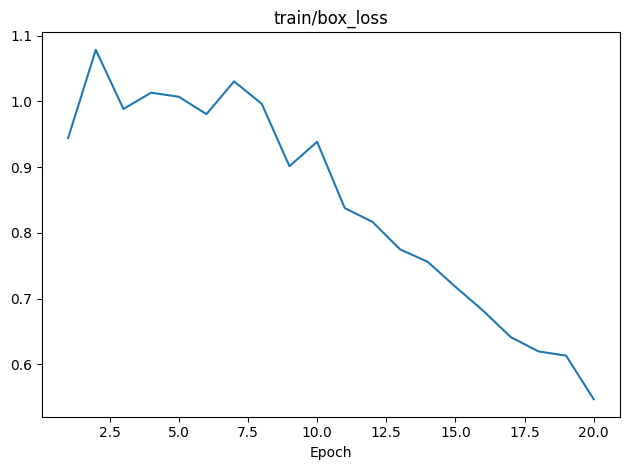

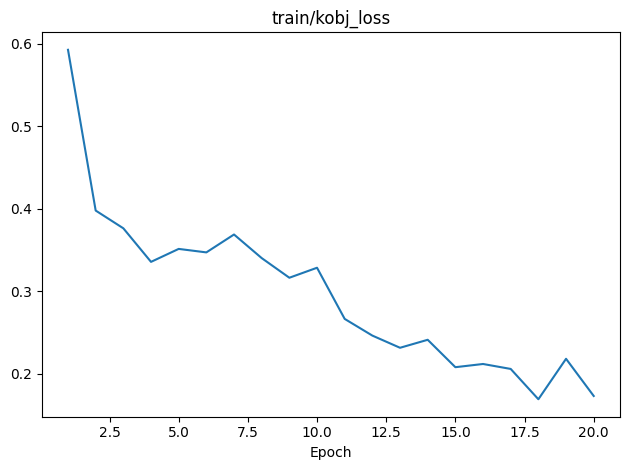

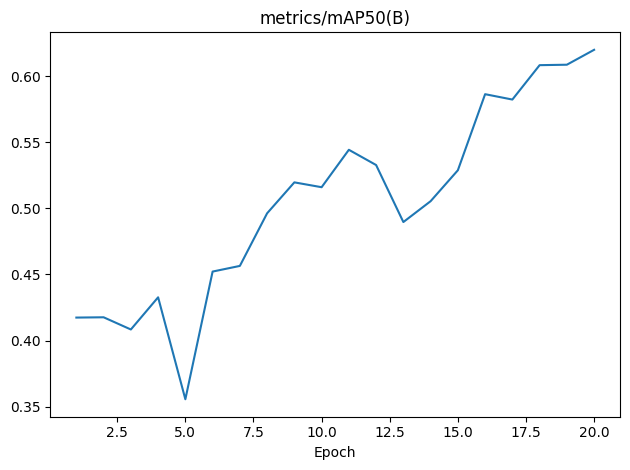

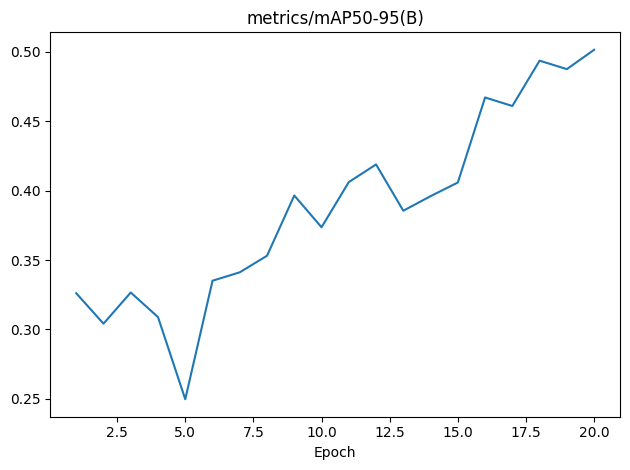

In [57]:
import pandas as pd, matplotlib.pyplot as plt, glob

csv_path = sorted(glob.glob(f"{PROJECT_TRAIN}/y8n_pose_finetuned/results.csv"))[-1]
df = pd.read_csv(csv_path)

for col in ["train/box_loss","train/kobj_loss","train/keypoint_loss",
            "metrics/mAP50(B)","metrics/mAP50-95(B)"]:
    if col in df.columns:
        plt.figure()
        plt.plot(df["epoch"], df[col])
        plt.title(col); plt.xlabel("Epoch"); plt.tight_layout(); plt.show()


## Quick bar chart of OKS mAP

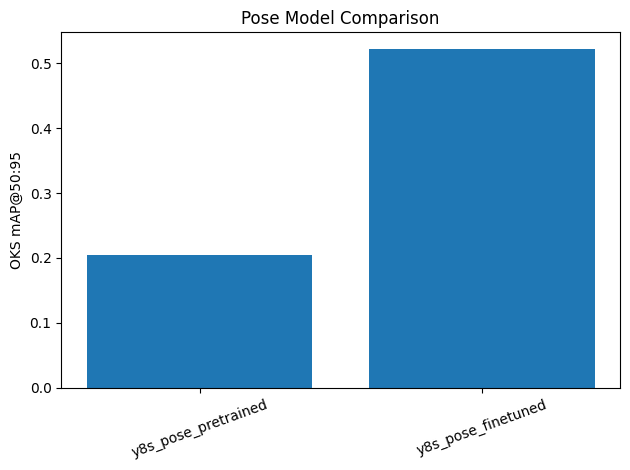

In [58]:
import matplotlib.pyplot as plt

plt.figure()
plt.bar(df_pose["model"], df_pose["mAP50-95(OKS)"])
plt.ylabel("OKS mAP@50:95")
plt.title("Pose Model Comparison")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()


# Improvements


## Config & helpers

In [59]:
# --- CONFIG ---
HORIZON_FRAMES = 2       # predict ~0.07s ahead @ 30FPS
HISTORY_FRAMES = 12      # past frames stored per fighter
EMA_ALPHA = 0.25         # smoothing for probabilities
WARMUP_FRAMES = 15       # frames to decide Red/Blue (left/right)
FPS_FALLBACK = 30.0

# Colors (BGR)
C_RED   = (0, 0, 255)
C_BLUE  = (255, 0, 0)
C_GRAY  = (160, 160, 160)

# COCO-17 skeleton edges (Ultralytics order)
COCO_EDGES = [
    (5,7),(7,9), (6,8),(8,10),
    (11,13),(13,15), (12,14),(14,16),
    (5,6), (11,12), (5,11),(6,12),
    (0,1),(1,2),(2,3),(3,4)
]

def draw_skeleton(frame, kpts_xy, color, radius=3, thick=2):
    if kpts_xy is None: return
    for a,b in COCO_EDGES:
        if a < len(kpts_xy) and b < len(kpts_xy):
            xa,ya = kpts_xy[a]; xb,yb = kpts_xy[b]
            if xa>0 and ya>0 and xb>0 and yb>0:
                cv2.line(frame,(int(xa),int(ya)),(int(xb),int(yb)), color, thick, cv2.LINE_AA)
    for (x,y) in kpts_xy:
        if x>0 and y>0:
            cv2.circle(frame,(int(x),int(y)), radius, color, -1, cv2.LINE_AA)

# dashed skeleton overlay
def draw_dashed_line(img, p1, p2, color, thickness=2, dash=10, gap=7):

    h, w = img.shape[:2]
    x1, y1 = int(p1[0]), int(p1[1])
    x2, y2 = int(p2[0]), int(p2[1])

    # Clamp points to image boundaries
    x1 = max(0, min(w-1, x1)); y1 = max(0, min(h-1, y1))
    x2 = max(0, min(w-1, x2)); y2 = max(0, min(h-1, y2))

    dist = int(np.hypot(x2 - x1, y2 - y1))
    if dist <= 0:
        return

    dx, dy = (x2 - x1) / dist, (y2 - y1) / dist

    n = 0
    while n * (dash + gap) < dist:
        start = n * (dash + gap)
        end = min(start + dash, dist)

        xs = int(x1 + dx * start); ys = int(y1 + dy * start)
        xe = int(x1 + dx * end);   ye = int(y1 + dy * end)

        # Clip each segment before drawing
        xs = max(0, min(w-1, xs)); ys = max(0, min(h-1, ys))
        xe = max(0, min(w-1, xe)); ye = max(0, min(h-1, ye))

        cv2.line(img, (xs, ys), (xe, ye), color, thickness, cv2.LINE_AA)
        n += 1

        n += 1

def draw_skeleton_dashed(frame, kpts_xy, color, joint_radius=3, thick=2, dash=10, gap=7):
    if kpts_xy is None: return
    for a,b in COCO_EDGES:
        if a < len(kpts_xy) and b < len(kpts_xy):
            xa,ya = kpts_xy[a]; xb,yb = kpts_xy[b]
            if xa>0 and ya>0 and xb>0 and yb>0:
                draw_dashed_line(frame, (xa,ya), (xb,yb), color, thickness=thick, dash=dash, gap=gap)
    for (x,y) in kpts_xy:
        if x>0 and y>0:
            cv2.circle(frame,(int(x),int(y)), joint_radius+1, color, 2, cv2.LINE_AA)

class EMA:
    def __init__(self, alpha=0.25, init_vec=None):
        self.alpha = alpha
        self.state = None if init_vec is None else np.array(init_vec, dtype=float)
    def update(self, vec):
        v = np.array(vec, dtype=float)
        if self.state is None: self.state = v
        else: self.state = self.alpha*v + (1.0-self.alpha)*self.state
        return self.state.copy()

def softmax(z):
    z = np.array(z, dtype=float); z -= np.max(z); e = np.exp(z)
    return e / (np.sum(e) + 1e-9)

def normalize01(x, lo, hi):
    return float(np.clip((x - lo) / (hi - lo + 1e-9), 0.0, 1.0))

# torso helpers (for fitting predicted pose)
def torso_center(kpts):
    if kpts is None: return None
    idxs = [5,6,11,12]
    pts = [kpts[i] for i in idxs if i < len(kpts)]
    pts = np.array([p for p in pts if p is not None])
    if len(pts) == 0: return None
    return np.nanmean(pts, axis=0)

def align_pose_to_torso(curr, fut):
    if curr is None or fut is None: return fut
    c_curr, c_fut = torso_center(curr), torso_center(fut)
    if c_curr is None or c_fut is None: return fut
    shift = c_curr - c_fut
    out = fut.copy(); out += shift
    return out


## Heuristic probabilities (kick/punch/block/none)

In [60]:
def kpt_speed(curr, prev):
    if curr is None or prev is None: return 0.0
    diffs = curr - prev
    return float(np.linalg.norm(diffs, axis=1).mean())

def height_rel(kpt, ref_y):
    if kpt is None: return 0.0
    return float(max(0.0, ref_y - kpt[1]))  # above hips (px)

def heuristic_probs(self_hist, opp_hist, frame_h):
    curr = self_hist[-1] if len(self_hist)>0 else None
    prev = self_hist[-2] if len(self_hist)>1 else None
    opp  = opp_hist[-1] if (opp_hist and len(opp_hist)>0) else None

    def pt(k, i):
        return None if (k is None or i>=len(k)) else k[i]

    lw, rw = pt(curr, 9),  pt(curr,10)   # wrists
    la, ra = pt(curr,15), pt(curr,16)    # ankles
    lh, rh = pt(curr,11), pt(curr,12)    # hips
    nose   = pt(curr,0)

    v_all = kpt_speed(curr, prev)
    opp_head = opp[0] if opp is not None else None

    def reach_prob(hand):
        if hand is None or opp_head is None: return 0.0
        d = np.linalg.norm(hand - opp_head)
        return 1.0 - normalize01(d, 0.05*frame_h, 0.6*frame_h)

    p_punch = max(reach_prob(lw), reach_prob(rw)) * normalize01(v_all, 1.0, 25.0)

    hip_y  = np.nanmean([rh[1] if rh is not None else frame_h, lh[1] if lh is not None else frame_h])
    foot_h = max(height_rel(la, hip_y), height_rel(ra, hip_y))
    p_kick = normalize01(foot_h, 0.0, 60.0) * normalize01(v_all, 1.0, 25.0)

    def near_face(hand):
        if hand is None or nose is None: return 0.0
        d = np.linalg.norm(hand - nose)
        return 1.0 - normalize01(d, 0.03*frame_h, 0.25*frame_h)
    guard   = max(near_face(lw), near_face(rw))
    p_block = guard * (1.0 - normalize01(v_all, 10.0, 35.0))

    logits = np.array([p_kick, p_punch, p_block, 0.3*(1.0 - max(p_kick,p_punch,p_block)) + 0.05])
    probs  = softmax(logits * 3.0)
    return {"kick": float(probs[0]), "punch": float(probs[1]), "block": float(probs[2]), "none": float(probs[3])}


## Future pose (constant velocity) + torso/head blending

In [61]:
def predict_future_pose(kpts_hist, horizon=HORIZON_FRAMES, dt=1.0):
    if len(kpts_hist) < 3 or kpts_hist[-1] is None or kpts_hist[-2] is None:
        return None
    p2 = kpts_hist[-1]; p1 = kpts_hist[-2]
    v  = (p2 - p1) / max(dt, 1e-9)
    return p2 + v * horizon

HEAD_FACE = [0,1,2,3,4]   # nose, eyes, ears
TORSO     = [5,6,11,12]   # shoulders & hips

def blend_future_pose(curr, fut, head_blend=0.85):
    if curr is None or fut is None:
        return fut if fut is not None else curr
    fut = fut.copy(); curr = curr.copy()
    for idx in TORSO:
        if idx < len(fut) and idx < len(curr):
            fut[idx] = curr[idx]
    for idx in HEAD_FACE:
        if idx < len(fut) and idx < len(curr):
            fut[idx] = head_blend * curr[idx] + (1.0 - head_blend) * fut[idx]
    return fut


## Minimal probability overlay (top-right, no background)

In [62]:
def draw_probs_overlay(frame, probs_by_id, id_to_role, margin=12):

    h, w = frame.shape[:2]
    x_right = w - margin
    y = margin + 10
    bar_height = 16
    bar_length = 150
    line_gap = 28

    # Title
    title = "Probabilities"
    (tw, th), _ = cv2.getTextSize(title, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 2)
    cv2.putText(frame, title, (x_right - tw, y),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,0,0), 2, cv2.LINE_AA)
    y += line_gap

    # Order fighters consistently (Red then Blue)
    order = []
    for tid in probs_by_id.keys():
        role = id_to_role.get(tid, "Fighter")
        order.append((0 if role=="Red Fighter" else 1, tid))
    order.sort()

    for _, tid in order:
        role = id_to_role.get(tid, "Fighter")
        color = C_RED if role=="Red Fighter" else C_BLUE

        # Fighter header
        label = f"{role} (ID {tid})"
        (tw, th), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.55, 2)
        cv2.putText(frame, label, (x_right - tw, y),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.55, (0,0,0), 2, cv2.LINE_AA)
        y += line_gap

        # Draw 3 bars: Kick, Punch, Block
        for action in ["kick", "punch", "block"]:
            p = float(probs_by_id[tid][action])
            bar_w = int(bar_length * p)
            x1 = x_right - bar_length
            x2 = x_right

            # Rail
            cv2.line(frame, (x1, y), (x2, y), (50,50,50), 2)
            # Value bar
            cv2.line(frame, (x2 - bar_w, y), (x2, y), color, 4)

            # Text
            txt = f"{action.capitalize()} {p:.2f}"
            (tw, th), _ = cv2.getTextSize(txt, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 2)
            cv2.putText(frame, txt, (x1 - tw - 8, y + 5),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 2, cv2.LINE_AA)
            y += bar_height + 8

        y += 6  # gap after fighter


## Runner: overlay everything on the original frame

In [63]:
from collections import defaultdict, deque

def run_overlay_video(
    src_path,
    save_prefix="overlay",
    conf=0.35, iou=0.45,
    tracker="bytetrack.yaml"
):
    src = Path(src_path)
    name = src.stem.strip().replace(" ", "_")

    # probe
    cap = cv2.VideoCapture(str(src))
    if not cap.isOpened():
        raise RuntimeError(f"Cannot open: {src}")
    fps = cap.get(cv2.CAP_PROP_FPS) or FPS_FALLBACK
    if fps <= 1: fps = FPS_FALLBACK
    W = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)) or 1280
    H = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)) or 720
    cap.release()

    # writer
    out_path = OUT_DIR /"Improvements"/ f"{save_prefix}_{name}_overlay.mp4"
    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    writer = cv2.VideoWriter(str(out_path), fourcc, fps, (W, H))
    if not writer.isOpened():
        out_path = OUT_DIR / f"{save_prefix}_{name}_overlay.avi"
        fourcc = cv2.VideoWriter_fourcc(*"MJPG")
        writer = cv2.VideoWriter(str(out_path), fourcc, fps, (W, H))
        if not writer.isOpened():
            raise RuntimeError("VideoWriter open failed.")

    # state
    id_to_hist = defaultdict(lambda: deque(maxlen=HISTORY_FRAMES))
    id_to_prob_ema = defaultdict(lambda: EMA(EMA_ALPHA, [0.12,0.12,0.12]))
    id_to_role = {}
    warm_pos = defaultdict(list)
    frame_idx = 0

    # stream
    gen = pose_model.track(
        source=str(src), conf=conf, iou=iou, classes=[PERSON_CLASS_ID],
        tracker=tracker, save=False, stream=True, verbose=False
    )

    for r in gen:
        frame = r.orig_img.copy() if hasattr(r, "orig_img") else r.plot()
        fh, fw = frame.shape[:2]

        # detections
        ids, boxes = [], []
        if r.boxes is not None:
            if r.boxes.id is not None:
                ids = [int(x) for x in r.boxes.id.cpu().numpy().tolist()]
            if r.boxes.xyxy is not None:
                boxes = r.boxes.xyxy.cpu().numpy().tolist()
        # keypoints (n,17,2)
        if hasattr(r, "keypoints") and r.keypoints is not None:
            try:
                kps = r.keypoints.xy.cpu().numpy()
            except:
                kps = r.keypoints.data[..., :2].cpu().numpy()
        else:
            kps = []

        # histories
        cur_by_id = {}
        for i, tid in enumerate(ids):
            this_k = kps[i] if i < len(kps) else None
            id_to_hist[tid].append(this_k)
            cur_by_id[tid] = this_k

        # roles (left/right after warmup)
        if frame_idx < WARMUP_FRAMES:
            for i, tid in enumerate(ids):
                if i < len(boxes) and boxes[i] is not None:
                    x1,y1,x2,y2 = boxes[i]
                    warm_pos[tid].append(0.5*(x1+x2))
        if frame_idx == WARMUP_FRAMES and not id_to_role:
            means = [(tid, np.mean(xs)) for tid, xs in warm_pos.items() if len(xs)>0]
            means.sort(key=lambda t: t[1])  # left→right
            if len(means) >= 1: id_to_role[means[0][0]] = "Red Fighter"
            if len(means) >= 2: id_to_role[means[1][0]] = "Blue Fighter"

        # per-id probs & predicted pose (fitted)
        ids_sorted = list(cur_by_id.keys())
        probs_for_overlay, fut_fitted = {}, {}
        for tid in ids_sorted:
            opp_tid = None
            if len(ids_sorted) > 1:
                opp_tid = ids_sorted[1] if ids_sorted[0]==tid else ids_sorted[0]

            self_hist = id_to_hist[tid]
            opp_hist  = id_to_hist[opp_tid] if opp_tid is not None else deque(maxlen=HISTORY_FRAMES)

            p = heuristic_probs(self_hist, opp_hist, fh)
            sm = id_to_prob_ema[tid].update([p["kick"], p["punch"], p["block"]])
            probs_for_overlay[tid] = {"kick": float(sm[0]), "punch": float(sm[1]), "block": float(sm[2])}

            fut = predict_future_pose(self_hist, horizon=HORIZON_FRAMES)
            fitted = blend_future_pose(cur_by_id.get(tid), fut, head_blend=0.85)
            fitted = align_pose_to_torso(cur_by_id.get(tid), fitted)
            fut_fitted[tid] = fitted

        # draw current boxes/labels/skeletons
        for i, tid in enumerate(ids):
            role = id_to_role.get(tid, "Fighter")
            col  = C_RED if role=="Red Fighter" else (C_BLUE if role=="Blue Fighter" else (0,255,0))
            if i < len(boxes):
                x1,y1,x2,y2 = map(int, boxes[i])
                cv2.rectangle(frame,(x1,y1),(x2,y2), col, 2)
                cv2.putText(frame,f"{role} (ID {tid})",(x1, max(20,y1-10)),
                            cv2.FONT_HERSHEY_SIMPLEX,0.7,col,2,cv2.LINE_AA)
            if i < len(kps):
                draw_skeleton(frame, kps[i], col, radius=3, thick=2)

        # draw predicted (dashed) on top
        for tid, fut in fut_fitted.items():
            role = id_to_role.get(tid, "Fighter")
            col  = C_RED if role=="Red Fighter" else (C_BLUE if role=="Blue Fighter" else (0,180,0))
            if fut is not None:
                draw_skeleton_dashed(frame, fut, col, joint_radius=3, thick=2, dash=10, gap=7)

        # top-right probabilities
        draw_probs_overlay(frame, probs_for_overlay, id_to_role, margin=12)

        writer.write(frame)
        frame_idx += 1

    writer.release()
    print("Saved overlay video:", out_path)
    return out_path


## Run

In [64]:
overlay_outputs = []
for v in videos:
    overlay_outputs.append(run_overlay_video(v, save_prefix="tri", tracker="bytetrack.yaml"))
overlay_outputs[:2]


Saved overlay video: /content/drive/MyDrive/DS5216/outputs/Improvements/tri_video_1_overlay.mp4
Saved overlay video: /content/drive/MyDrive/DS5216/outputs/Improvements/tri_video_2_overlay.mp4
Saved overlay video: /content/drive/MyDrive/DS5216/outputs/Improvements/tri_video_3_overlay.mp4
Saved overlay video: /content/drive/MyDrive/DS5216/outputs/Improvements/tri_video_4_overlay.mp4
Saved overlay video: /content/drive/MyDrive/DS5216/outputs/Improvements/tri_video_5_overlay.mp4
Saved overlay video: /content/drive/MyDrive/DS5216/outputs/Improvements/tri_video_6_overlay.mp4


[PosixPath('/content/drive/MyDrive/DS5216/outputs/Improvements/tri_video_1_overlay.mp4'),
 PosixPath('/content/drive/MyDrive/DS5216/outputs/Improvements/tri_video_2_overlay.mp4')]